In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import Exponential, Uniform
import math
import torch.nn as nn
from typing import Tuple
from torch.autograd import Variable
import itertools
import math 
from scipy.stats import entropy
from scipy.stats import truncnorm

# Define Functions to Generate Shared Codebook (Randomness)

In [2]:
def entropy1(labels, base=2):
    value,counts = np.unique(labels, return_counts=True)
    return entropy(counts, base=base)

def torch_to_numpy(tensor):
    tensor=tensor.detach()
    if isinstance(tensor, torch.Tensor):
        if tensor.is_cuda:
            tensor = tensor.cpu()
        return tensor.numpy()
    else:
        raise ValueError("Input must be a Torch tensor.")

def generate_logexp(B=128, N=1024):
    exp = torch.cuda.FloatTensor(B, N, 1).exponential_()
    return torch.log(exp)

def generate_M(B=128, N=1024, dim=1, L=2): #log_2(L) bits only
    """random_tensor = torch.cuda.FloatTensor(B, N).random_(L).long()
    return random_tensor"""
    #random_tensor = torch.cuda.FloatTensor(B, N).random_(L).long()
    M = np.arange(L)
    M = np.repeat(M, int(N/L))
    M = torch.from_numpy(M).cuda() #torch.Tensor(M).cuda()
    """M = torch.arange(L).cuda()
    M = M.repeat(int(N/L))"""
    M = M[None, ...].long()
    return M

def generate_prior(B=128, N=1024, dim=1, var=1.01):
    # Generate Gaussian samples with mean 0 and the predefined variance
    gaussian_samples = torch.cuda.FloatTensor(B, N,dim).normal_(0, 1) * np.sqrt(var)
    #torch.randn((B,N,dim )) * np.sqrt(var)
    return gaussian_samples


def generate_common_randn(B=128, N=1024,dim=1,L=2, var=1.01):
    S = generate_logexp(B,N)
    M = generate_M(B,N,1,L)
    U = generate_prior(B, N, dim, var)
    return (S, M, U)

def gaussian_log_prob(x, mean, variance):
    log_prob = -0.5 * (math.log(2 * math.pi * variance) + ((x - mean) ** 2) / variance)
    return log_prob

# Gumbel Max Selection.

In [3]:
def compute_enc(logS_, U_, X_, var_u_, var_u_x_):

    log_p_ = gaussian_log_prob(U_, 0, var_u_).sum(dim=-1, keepdim=True)
    log_t_ = gaussian_log_prob(U_, X_, var_u_x_).sum(dim=-1, keepdim=True) # PROBABLY WRONG <PLEASE CHECK>
    score_x_ = logS_ + log_p_ - log_t_
    scale_ = logS_ + log_p_ 
    
    argmin_indices_encoder_ = torch.argmin(score_x_, dim=1)
    selected_values_ = U_[torch.arange(score_x_.shape[0]), argmin_indices_encoder_[:,0]]
    return argmin_indices_encoder_, selected_values_, scale_

# Experiment. 

In [4]:
def matching_exp(N=2**20, b_size=1, dim=1, total_epochs=4096, mean_u_x = -1.0, mean_u_y = 1.0,
                var_u_x= 1.0, var_u_y=1.0, var_u = 4.0):
    c=0
    with torch.no_grad():
        list_index = []
        wait_t = []
        list_X = []
        list_X_hat = []
        
        for tuoc in range(total_epochs):
            #print (tuoc)
            logS,_,U = generate_common_randn(B=b_size, N=N, dim=dim, L=2, var=var_u)
            
            logS = logS.cuda()
            U = U.cuda()
            argmin_idx_alice, val_alice,_ = compute_enc(logS, U, mean_u_x, var_u, var_u_x)
            argmin_idx_bob, val_bob,_     = compute_enc(logS, U, mean_u_y, var_u, var_u_y)
            
            argmin_idx_alice = int(argmin_idx_alice.cpu().detach().numpy())
            argmin_idx_bob = int(argmin_idx_bob.cpu().detach().numpy())
            
            if argmin_idx_alice == argmin_idx_bob:
                c +=1
                
    return c/float(total_epochs)

In [5]:
means_=[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]
match=[]

for mean in means_:
    print (mean)
    match.append(matching_exp(mean_u_x=-mean, mean_u_y=mean, total_epochs=2**15))
means_ = np.asarray(means_)
match = np.asarray(match)

0.0


/tmp/ipykernel_72158/3534932613.py:15: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  exp = torch.cuda.FloatTensor(B, N, 1).exponential_()


0.25
0.5
0.75
1.0
1.25
1.5
1.75
2.0


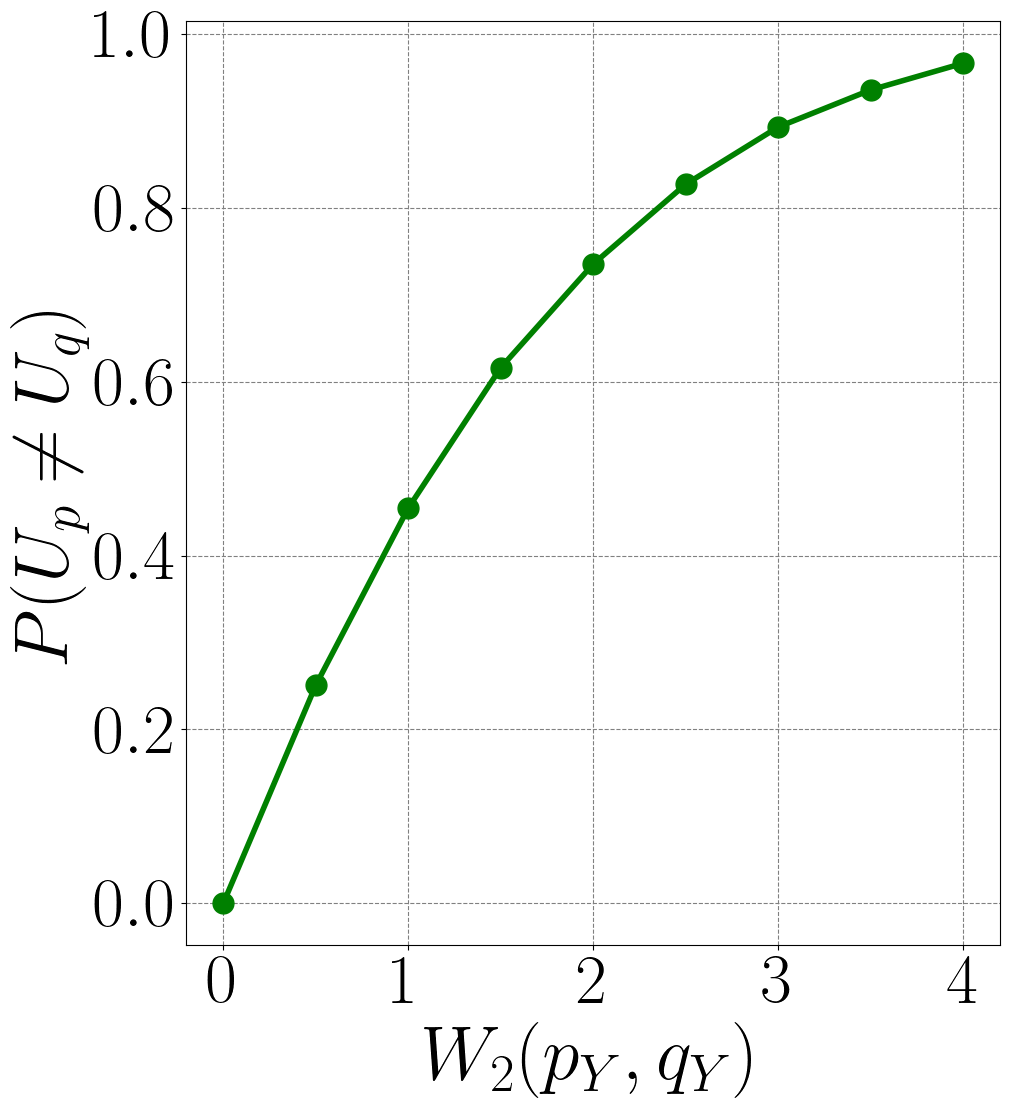

In [6]:
plt.rcParams['text.usetex'] = True
font = {'family' : 'normal',
        'size'   : 36}
plt.rc('font', **font)

fig = plt.figure(figsize=(10.5, 12))
plt.rc('grid', linestyle="-", color='grey')

plt.plot(means_*2, 1-match, '-go', linewidth=4.0, markersize=15)   
plt.ylabel(r'$P(U_p\neq U_q)$', fontsize=55)
plt.xlabel('$W_2(p_Y, q_Y)$', fontsize=55)

plt.xticks(fontsize=50)
plt.yticks(fontsize=50)

#plt.title('Empirical Matching Probabilities')
#plt.grid(True)
plt.grid(linestyle='--',linewidth=0.8)

#plt.savefig('match1.pdf',bbox_inches='tight', pad_inches=0)

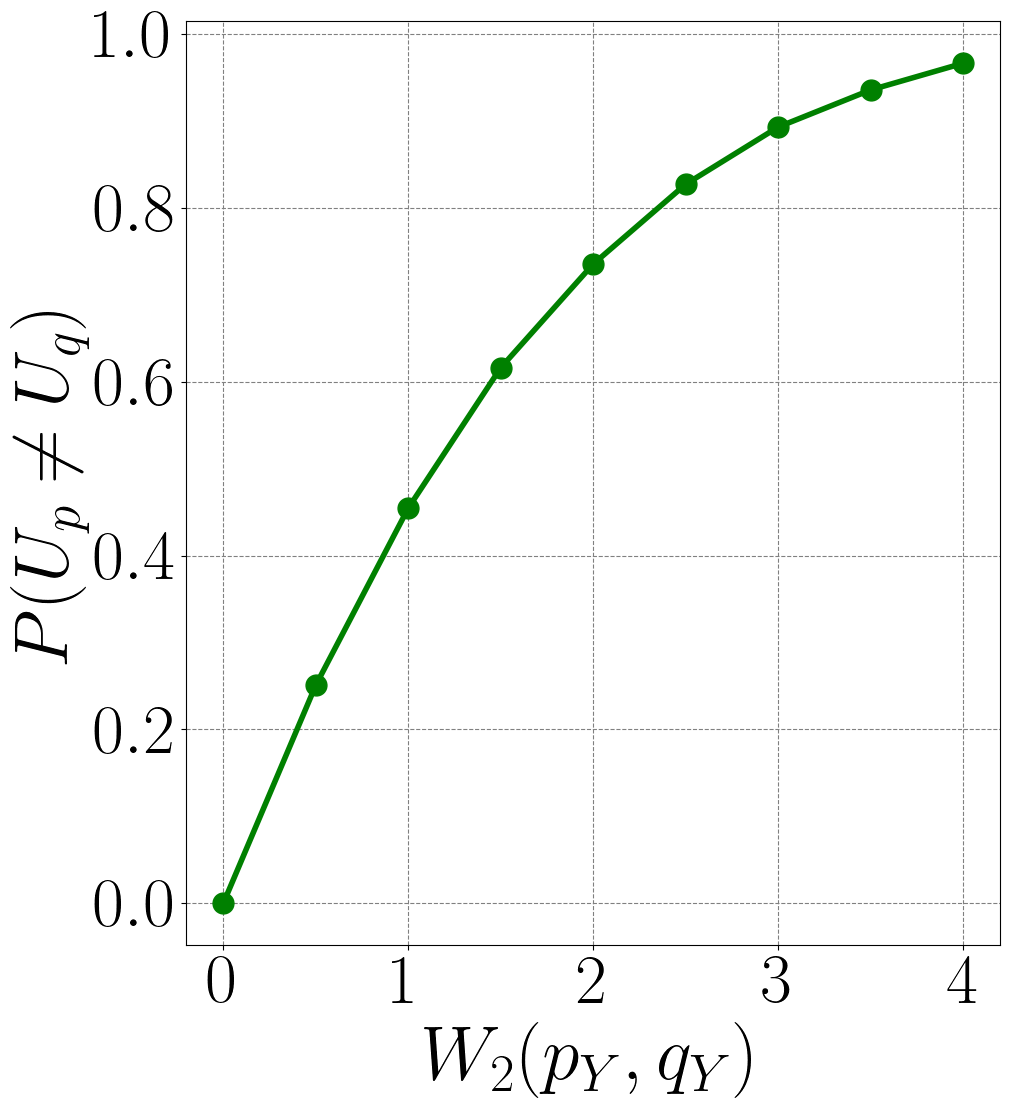

In [7]:
plt.rcParams['text.usetex'] = True
font = {'family' : 'normal',
        'size'   : 36}
plt.rc('font', **font)

fig = plt.figure(figsize=(10.5, 12))
plt.rc('grid', linestyle="-", color='grey')

plt.plot(means_*2, 1-match, '-go', linewidth=4.0, markersize=15)   
plt.ylabel(r'$P(U_p\neq U_q)$', fontsize=55)
plt.xlabel('$W_2(p_Y, q_Y)$', fontsize=55)

plt.xticks(fontsize=50)
plt.yticks(fontsize=50)

#plt.title('Empirical Matching Probabilities')
#plt.grid(True)
plt.grid(linestyle='--',linewidth=0.8)

#plt.savefig('match1.pdf',bbox_inches='tight', pad_inches=0)